# Problem Statement

Predicting the voting behavior of a voter is of vital importance for political campaigns (and many other entities), for accurate targeting. However, current methods (to be discussed furthe in the final project submission) lack both generlizability and interpretability. In this project, we'll explore how voter demographics and past voting history indicate a voter's likelihood to vote in a given election, and how accurately understandable models can be built to predict this propensity.

Data is collected from an export of the Pennsylvania Full Voter File, which is publicly available and contains the voting history and demographics of all currently registered voters in the state. We will explore models' ability to both predict on some voters in a given election (having trained on other voters in the same election), and to predict on voters in an unseen election, where there are new unseen but very important features (past response variables which have now become election history for a voter). In this second case, we will use a sliding window approach to build a model which learns features that are relative to the response variable election, allowing for smooth generalization to new elections.

# Exploration and Visualization

Data from the raw voter file is first processed in `process_pa_data.py`. Run this script to generate all necessary processed data.

EDA and visualization is then run in the notebook `eda.ipynb`.

# Model Building and Evaluation

In this notebook, we'll use the processed voter data, along with the interpretation of the EDA, to build models to predict voter turnout.

In [3]:
import itertools
import json
import os
import sys

import pandas as pd
from tqdm import tqdm

from config import (FEATURES_FILE, MAJOR_ELECTIONS_DATES_FILE,
                    PROCESSED_DATA_DIR, SLIDING_WINDOW_FILE,
                    TEN_PCT_SAMPLE_FILE, election_date_to_feature_names)

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## Sliding Window Dataset Creation
Next, we need to create a sliding window dataset, where each sample is a continuous subset of one voter's election features, such that a model can learn to predict differing elections as the response variable. First, let's figure out which elections we have sufficient data for (for a sliding window approach, high feature presence will be important, since imputation on election features that are only relative in time may lead to weird model behavior).

In [2]:
# NOTE: This cell takes a long time to run, so don't re-run it unless needed. It is not needed for the rest of the notebook.

# Find the percent of all samples which have each election date

major_elections = json.load(open(MAJOR_ELECTIONS_DATES_FILE))["dates"]

num_total = 0
num_sampled = [0] * len(major_elections)

for file in tqdm(
    os.listdir(PROCESSED_DATA_DIR), desc="Reading files", unit="file", colour="green"
):
    if file.endswith(".csv"):
        if file == TEN_PCT_SAMPLE_FILE:
            continue
        else:
            df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, file))

            num_total += len(df)

            for date in major_elections:
                presence_column = f"Election {date} Presence"

                if presence_column in df.columns:
                    num_sampled[major_elections.index(date)] += df[presence_column].sum()

for i in range(len(major_elections)):
    print(f"{major_elections[i]}: has {num_sampled[i]} samples and {num_sampled[i] / num_total * 100:.2f}% existance")


Reading files: 100%|██████████| 71/71 [03:20<00:00,  2.82s/file]

11/04/2003: has 1860273 samples and 19.67% existance
04/27/2004: has 3437031 samples and 36.35% existance
11/02/2004: has 4484242 samples and 47.42% existance
05/17/2005: has 6635385 samples and 70.17% existance
11/08/2005: has 7313625 samples and 77.34% existance
05/16/2006: has 7343628 samples and 77.66% existance
11/07/2006: has 7343628 samples and 77.66% existance
05/15/2007: has 8471785 samples and 89.59% existance
11/06/2007: has 8471785 samples and 89.59% existance
04/22/2008: has 9456662 samples and 100.00% existance
11/04/2008: has 9456662 samples and 100.00% existance
05/19/2009: has 9456662 samples and 100.00% existance
11/03/2009: has 9456662 samples and 100.00% existance
05/18/2010: has 9456662 samples and 100.00% existance
11/02/2010: has 9456662 samples and 100.00% existance
05/17/2011: has 9456662 samples and 100.00% existance
11/08/2011: has 9456662 samples and 100.00% existance
04/24/2012: has 9456662 samples and 100.00% existance
11/06/2012: has 9456662 samples and 1

We can see that all elections since the primary in 2008 have 100% feature presence. Thus, we can built a sliding window dataset with no needed imputation by using only these election years. So, we're left with 30 elections, for which we'll use 10 sliding windows of 20 features (10 years) and1 response variable each.

Optimally, we would sample the full dataset on each sliding window (thus, a 100% sample), but this would result in about 100,000,000 samples (10 sliding windows $\times$ 10,000,000 voters). To balance computational cost, we'll sample 10% of the data for now, which will result in about 10,000,000 samples.

In [3]:
feature_election_dates = json.load(open(MAJOR_ELECTIONS_DATES_FILE))["feature_dates"]

demographic_features = json.load(open(FEATURES_FILE))["demographic"]

# Allow for 10 years of election history and 1 response variable election
SLIDING_WINDOW_LENGTH = 21
num_sliding_windows = len(feature_election_dates) - SLIDING_WINDOW_LENGTH + 1

# Use the election names "T - 1", "T - 2", etc. for the feature elections
# However, we've decided to only use elections which have 100% presence, so "Presence" columns are redundant
sliding_election_column_names = list(
    itertools.chain.from_iterable(
        [
            [feat for feat in election_date_to_feature_names(f"T-{i}") if "Presence" not in feat]
            for i in range(SLIDING_WINDOW_LENGTH - 1, 0, -1)
        ]
    )
)

# Remove the features which would cause leakage in the sliding window approach
sliding_demographic_features = [feature for feature in demographic_features if "Gender" in feature]

sliding_features = sliding_demographic_features + sliding_election_column_names + ["Response"]

df = pd.DataFrame(columns=sliding_features)

Above, we've removed some demographic features for this sliding window approach for simplicity. For example, `Registration Date`, `Last Vote Date`, etc. have been removed, and most importantly, `DOB` has been removed. For all these features, including them would require that, for each sample, we re-calculate their value, since they are dates or ages. For `DOB`, the age of the voter would need to be adjusted for each election year. For this version, we have left this out in the interest of testing general model ability on this data. However, we plan to include it in our final version.

In [4]:
dfs = []

# Now, read in the data and sample for each sliding window
for i, file in enumerate(tqdm(
    os.listdir(PROCESSED_DATA_DIR), desc="Reading files", unit="file", colour="green"
)):
    if file.endswith(".csv"):
        if file == TEN_PCT_SAMPLE_FILE:
            continue
        else:
            df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, file))

            # Sample each sliding window
            for i in range(num_sliding_windows):
                # Gather the election features for the current sliding window
                election_columns = list(
                    itertools.chain.from_iterable(
                        [feat for feat in election_date_to_feature_names(date) if "Presence" not in feat]
                        for date in feature_election_dates[i : i + SLIDING_WINDOW_LENGTH - 1]
                    )
                )

                # Gather the response variable election for the current sliding window
                response_column = f"Election {feature_election_dates[i + SLIDING_WINDOW_LENGTH - 1]} Voted"

                all_selected_columns = sliding_demographic_features + election_columns + [response_column]

                # Sample the data
                df_sample = df[all_selected_columns].sample(frac=0.01)
                df_sample.columns = sliding_features

                dfs.append(df_sample)

df = pd.concat(dfs)
df.to_csv(SLIDING_WINDOW_FILE, index=False)

Reading files: 100%|██████████| 71/71 [03:38<00:00,  3.07s/file]


For now, we've included voters in this dataset which were actually registered after the response election dates. For example, an 20 year old voter now should not be in sliding window whose response variable is more than 2 years ago, since that voter will have no elections present. Further, this voter's presence is "confusing" for the model, since it would be impossible for this voter to be in an unseen dataset for a new election year. For the final version, we will check the `DOB` and eliminate voters from the sample which could never have been in the voter file at that time.

Note that there is still some bias introduced which we cannot overcome, from voters which have been eliminated from the file since the response election date. Those voters may have died or moved, but we'd like our model to still learn from them. The only solution to this is to request the voter files from those dates, but this would (for us) be too time-consuming and expensive.

## Decision Tree

Next, we'll build a decision tree with the sliding window dataset. This will be the first baseline model.

In [4]:
# In case the above cell is not run, read in the data from the file
try:
    df
except NameError:
    df = pd.read_csv(SLIDING_WINDOW_FILE)

# Separating the features and target variable
X = df.drop(['Response'], axis=1)
y = df['Response']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=109)

# Initializing the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=109)

# Training the model
dt_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred = dt_classifier.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [11]:
print(f"The model's accuracy is {accuracy * 100:.2f}%\n")
print(report)

The model's accuracy is 80.26%

              precision    recall  f1-score   support

           0       0.82      0.89      0.85    200093
           1       0.77      0.65      0.70    111711

    accuracy                           0.80    311804
   macro avg       0.79      0.77      0.78    311804
weighted avg       0.80      0.80      0.80    311804



Next, let's make a ROC curve, so we can visualize the model's performance across varying thresholds.

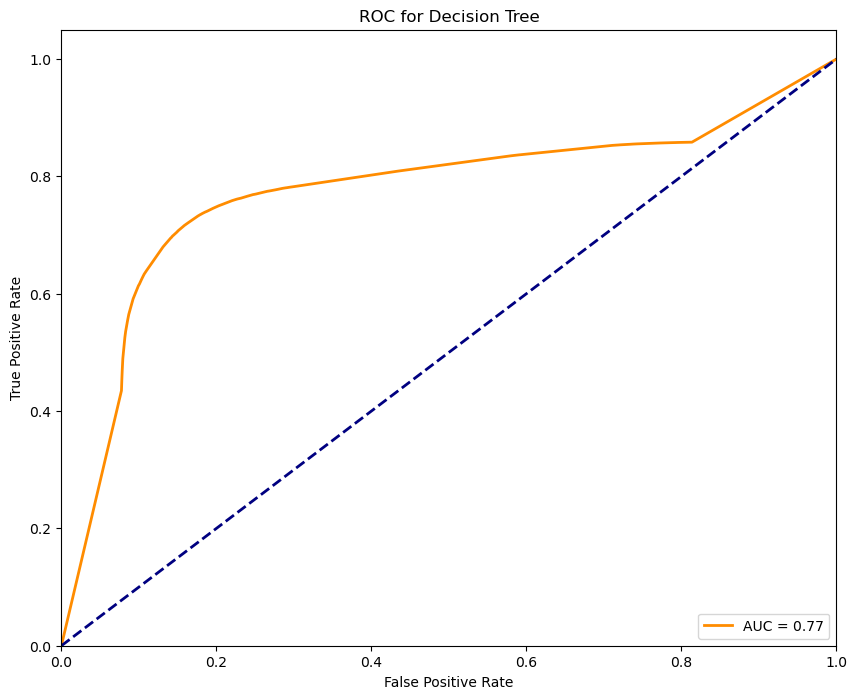

In [25]:
# Calculate the probability scores of each point in the test set
y_scores = dt_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Decision Tree')
plt.legend(loc="lower right")
plt.show()

The AUC curve is shaped relatively as expected, with a 

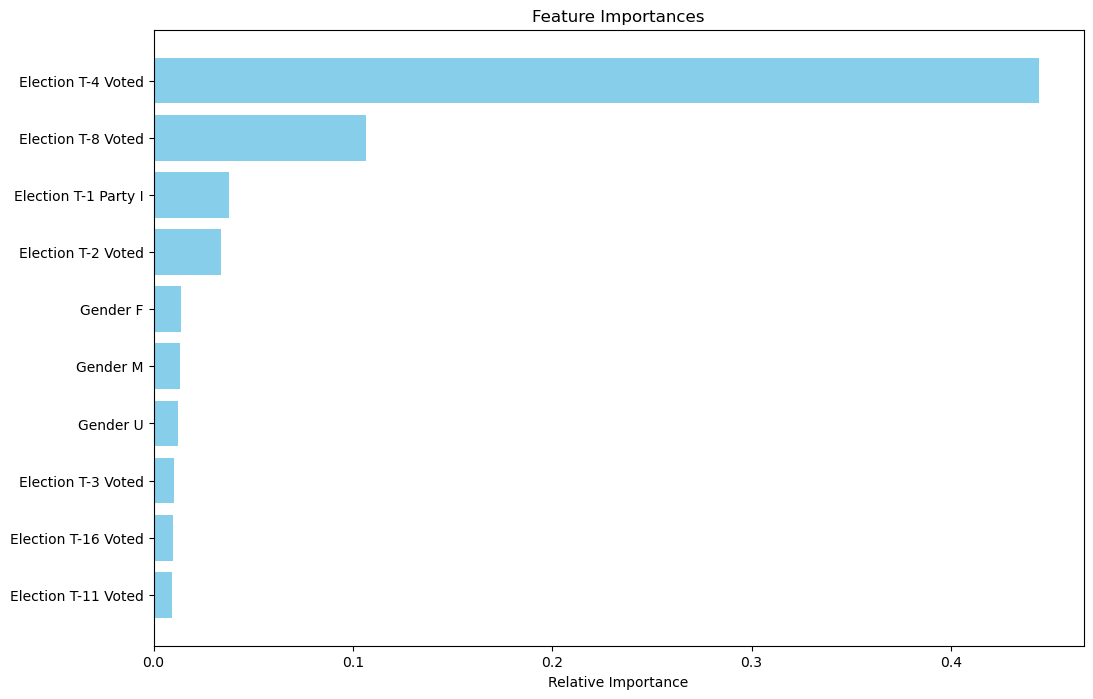

In [18]:
# Get feature importances from the decision tree model
feature_importances = dt_classifier.feature_importances_

# Create a DataFrame to hold the feature names and their importance scores
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(features_df['Feature'][:10], features_df['Importance'][:10], color='skyblue')
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()
plt.show()

As expected, the best predictors of turnout in an election are the most recent similar elections. In this case, the best predictor was by far the election 2 years ago (`T-4`). For example, for a major presidential election (which only occurs every 4 years), the best predictor is the major general election 2 years ago, which has major statewide races. The next best predictor is the election 4 years ago (`T-4`), which is of the exact same type (with the same type of races). Further, the fourth best predictor is the election from 2 years ago, which is of the same type (primary or general), but may be a slightly different type (large statewide races instead of national presidential ones). This is a good sign that the model is learning the correct features.

A voter's one-hot Independent party registration is the 3rd best predictor of an election. This is likely because Independents cannot vote in primaries, and thus this feature is a perfect predictor for some elections. However, due to the sliding window approach, this feature does not apply the same to every election. In the next version, we'll attempt to address this concern, likely by adding a feature which indicates whether the response variable election is a primary or general election.

After this, the gender of the voter and random other election years are the next best elections, indicating most of the decision-making is coming from these first few features.

## Random Forest

Next, we'll build a random forest with the sliding window dataset. Random forest models can be more accurate than decision trees, but are more difficult to interpret.

In [8]:
# Initializing the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

# Training the model
rf_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Evaluating the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [9]:
print(f"The model's accuracy is {accuracy_rf * 100:.2f}%\n")
print(report_rf)

The model's accuracy is 82.24%

              precision    recall  f1-score   support

           0       0.84      0.89      0.87    200093
           1       0.78      0.70      0.74    111711

    accuracy                           0.82    311804
   macro avg       0.81      0.80      0.80    311804
weighted avg       0.82      0.82      0.82    311804



This model performs slightly better than the decision tree, with an accuracy of 82% at a threshold of 0.5. The AUC curve is also slightly better, with an AUC of 0.87 instead of 0.77.

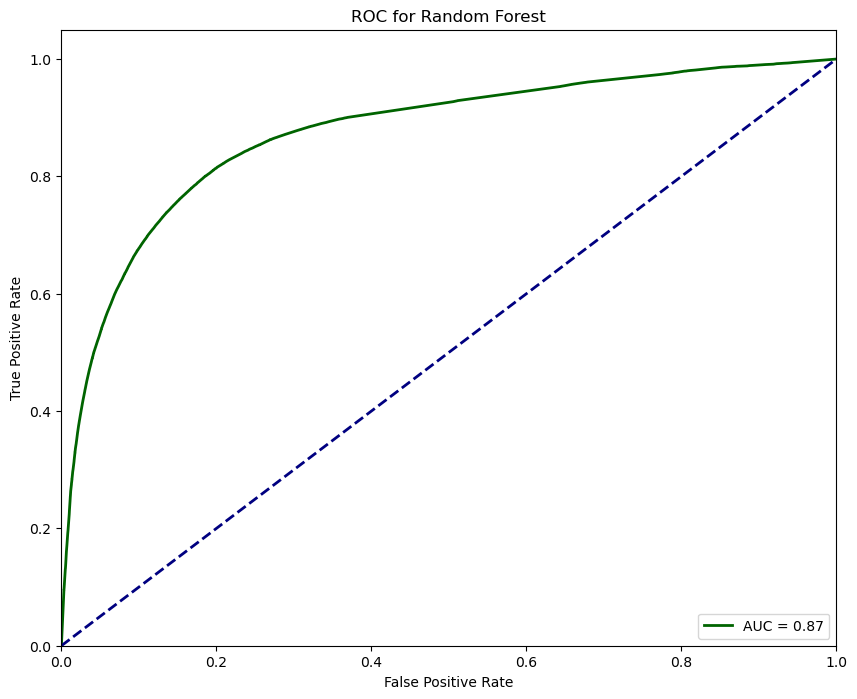

In [26]:
# Calculate the probability scores of each point in the test set for the random forest model
y_scores_rf = rf_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for the random forest model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_scores_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotting the ROC Curve for the random forest model
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, color='darkgreen', lw=2, label='AUC = %0.2f' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Random Forest')
plt.legend(loc="lower right")
plt.show()

This curve is shaped more normally than the decision tree, with a more gradual increase in accuracy as the threshold increases.

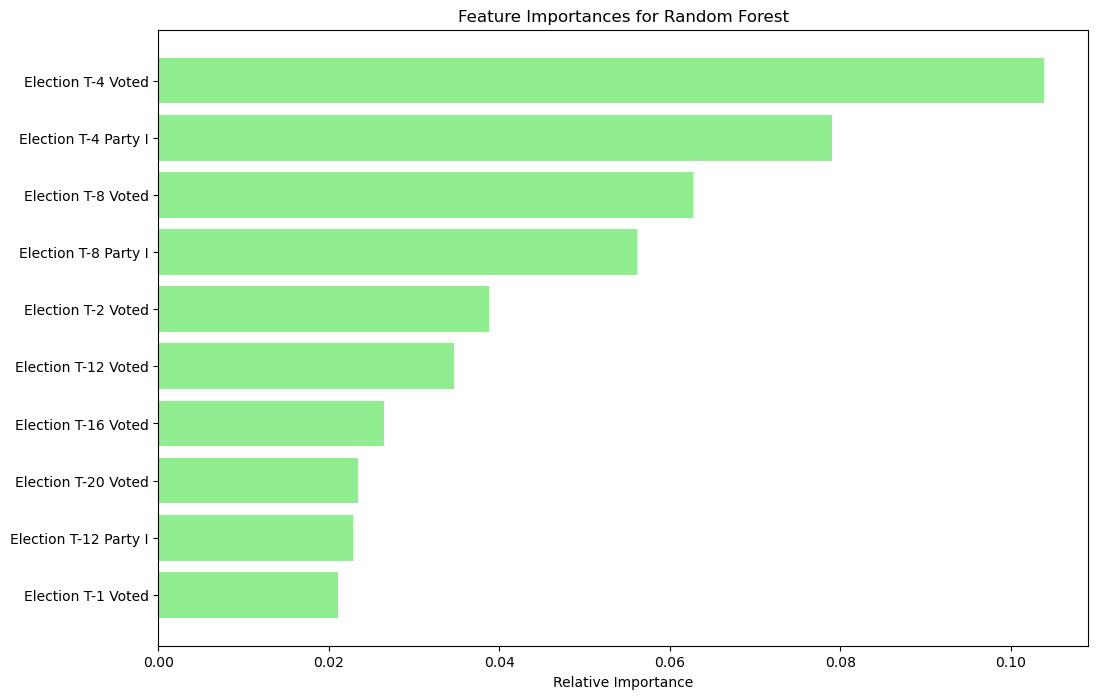

In [24]:
# Get feature importances from the random forest model
feature_importances_rf = rf_classifier.feature_importances_

# Create a DataFrame to hold the feature names and their importance scores for the random forest model
features_df_rf = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_rf})

# Sort the DataFrame by importance in descending order
features_df_rf = features_df_rf.sort_values(by='Importance', ascending=False)

# Plotting the feature importances for the random forest model
plt.figure(figsize=(12, 8))
plt.title('Feature Importances for Random Forest')
plt.barh(features_df_rf['Feature'][:10], features_df_rf['Importance'][:10], color='lightgreen')
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis() 
plt.show()


As expected, the random forest model has a much more even distribution of feature importance. Still, the elections from 2 years ago and 4 years ago are in the top 3 features, indicating that the model is learning the correct features. Here, the voter's Independent one-hot feature is the second-most important feature, likely for the same reason as above.

## Final Model Pipeline

Next, we'll make the changes described throughout the above sections to improve these models (removing voters which shouldn't exist, adding back date-based demographic features, etc.). We'll also add a boosting model to the pipeline to compare its performance to the previous models. Then, we'll interpret all the models together, and the conclusions they lead to about the general trends in voting behavior.